# Exploration of the train_app_downloads.csv file.

We explore the train_app_downloads.csv file.

In [1]:
# Moving average for the polynom
# Try with the logs
# Separate iphone and ipad
# Put some cross Validation
# Combine
#Use the number of 0 as a predictor


#imported libraries
import pandas as pd
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [24]:
#Creating of the input data
downloads = pd.read_csv('train_app_downloads.csv')
output = pd.read_csv('train_final_downloads.csv')
dateRange = pd.date_range('2015-03-01', periods=56).format(formatter=lambda x: x.strftime('%Y-%m-%d'))

In [40]:
#We map -1 to 0 in the downloads (there are no 0 in the initial data)
replacementValue=0
downloads = downloads.replace(-1,replacementValue)

In [4]:
#Generate the id of the "good" and "bad" apps
badAppId=(output.sort_values(["cumulative_downloads_2016-02"],ascending=True)[100:120]["id"].values)
goodAppId=(output.sort_values(["cumulative_downloads_2016-02"],ascending=False)[100:120]["id"].values)

In [5]:
#In these new dataframes, only the "good" or "bad" apps remain
goodAppDownloads=downloads[downloads["id"].isin(goodAppId)]
badAppDownloads=downloads[downloads["id"].isin(badAppId)]

In [6]:
#Convert these dataFrames to matrices with only the downloads remaining
MGood=downloads[downloads["id"].isin(goodAppId)][dateRange].as_matrix()
MBad=downloads[downloads["id"].isin(badAppId)][dateRange].as_matrix()

## Predictor Extraction

In [7]:

#Create a sum of the downloads for each week
predictors = pd.concat([downloads["id"],downloads["name"],downloads["category"],downloads["device"],
   downloads['2015-03-01']+downloads['2015-03-02']+downloads['2015-03-03']+downloads['2015-03-04']+downloads['2015-03-05']+downloads['2015-03-06']+downloads['2015-03-07'],
   downloads['2015-03-08']+downloads['2015-03-09']+downloads['2015-03-10']+downloads['2015-03-11']+downloads['2015-03-12']+downloads['2015-03-13']+downloads['2015-03-14'],
   downloads['2015-03-15']+downloads['2015-03-16']+downloads['2015-03-17']+downloads['2015-03-18']+downloads['2015-03-19']+downloads['2015-03-20']+downloads['2015-03-21'],
   downloads['2015-03-22']+downloads['2015-03-23']+downloads['2015-03-24']+downloads['2015-03-25']+downloads['2015-03-26']+downloads['2015-03-27']+downloads['2015-03-28'],
   downloads['2015-03-29']+downloads['2015-03-30']+downloads['2015-03-31']+downloads['2015-04-01']+downloads['2015-04-02']+downloads['2015-04-03']+downloads['2015-04-04'],
   downloads['2015-04-05']+downloads['2015-04-06']+downloads['2015-04-07']+downloads['2015-04-08']+downloads['2015-04-09']+downloads['2015-04-10']+downloads['2015-04-11'],
   downloads['2015-04-12']+downloads['2015-04-13']+downloads['2015-04-14']+downloads['2015-04-15']+downloads['2015-04-16']+downloads['2015-04-17']+downloads['2015-04-18'],
   downloads['2015-04-19']+downloads['2015-04-20']+downloads['2015-04-21']+downloads['2015-04-22']+downloads['2015-04-23']+downloads['2015-04-24']+downloads['2015-04-25'],             
   ],axis=1,keys=["id","name","category","device","week1","week2","week3","week4","week5","week6","week7","week8"])


In [8]:
predictors = pd.concat([downloads["id"],downloads["name"],downloads["category"],downloads["device"],
   (downloads['2015-03-01']+downloads['2015-03-02']+downloads['2015-03-03']+downloads['2015-03-04']+downloads['2015-03-05']+downloads['2015-03-06']+downloads['2015-03-07']+
   downloads['2015-03-08']+downloads['2015-03-09']+downloads['2015-03-10']+downloads['2015-03-11']+downloads['2015-03-12']+downloads['2015-03-13']+downloads['2015-03-14']+
   downloads['2015-03-15']+downloads['2015-03-16']+downloads['2015-03-17']+downloads['2015-03-18']+downloads['2015-03-19']+downloads['2015-03-20']+downloads['2015-03-21']+
   downloads['2015-03-22']+downloads['2015-03-23']+downloads['2015-03-24']+downloads['2015-03-25']+downloads['2015-03-26']+downloads['2015-03-27']+downloads['2015-03-28']+
   downloads['2015-03-29']+downloads['2015-03-30']+downloads['2015-03-31']+downloads['2015-04-01']+downloads['2015-04-02']+downloads['2015-04-03']+downloads['2015-04-04']+
   downloads['2015-04-05']+downloads['2015-04-06']+downloads['2015-04-07']+downloads['2015-04-08']+downloads['2015-04-09']+downloads['2015-04-10']+downloads['2015-04-11']+
   downloads['2015-04-12']+downloads['2015-04-13']+downloads['2015-04-14']+downloads['2015-04-15']+downloads['2015-04-16']+downloads['2015-04-17']+downloads['2015-04-18']+
   downloads['2015-04-19']+downloads['2015-04-20']+downloads['2015-04-21']+downloads['2015-04-22']+downloads['2015-04-23']+downloads['2015-04-24']+downloads['2015-04-25'])/56             
   ],axis=1,keys=["id","name","category","device","daily_avg"])


In [9]:
predictors = pd.concat([downloads["id"],downloads["name"],downloads["category"],downloads["device"]],axis=1,keys=["id","name","category","device"])
old_predictors = pd.concat([downloads["id"],downloads["name"],downloads["category"],downloads["device"]],axis=1,keys=["id","name","category","device"])

In [10]:
#Generate the weekly average
def generator_weekAvg(inp,w):
    if (np.count_nonzero(inp[5+w*7:12+w*7] - replacementValue*np.ones(len(inp[5+w*7:12+w*7]))) == 0):
        return 0
    return  math.log(1.0*sum(inp[5+w*7:12+w*7])/np.count_nonzero(inp[5+w*7:12+w*7] - replacementValue*np.ones(len(inp[5+w*7:12+w*7]))))
    #return  math.log(1.0*sum(inp[5:])/len(inp[5:]))

for w in range(8):
    predictors["week_"+str(w+1)] = downloads.apply(generator_weekAvg,axis=1,args=(w,))
    old_predictors["week_"+str(w+1)] = downloads.apply(generator_weekAvg,axis=1,args=(w,))

In [11]:
#Generate the daily average
def generator_dailyAvg(inp):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    return  (1.0*sum(inp[5:])/np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))))
    #return  math.log(1.0*sum(inp[5:])/len(inp[5:]))

predictors["daily_avg"] = downloads.apply(generator_dailyAvg,axis=1)

In [12]:
#Generate the polynomial coefficients
def generator_coef(inp, coef):
    return  np.polyfit(range(56),inp[5:],coef)[0]
#Redo by ignoring the -1 / 0 ? w = [1110011]     w = np.not_equal(inp[5:],np.ones(len(inp[5:]))*replacementValue

for c in range(4):
    predictors["coef_"+str(c)] = downloads.apply(generator_coef,axis=1,args=(c,))


In [48]:
#Generate the step max and min (we ignore the values of 0)
def generator_maxStep(inp,maximum):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    m = 0
    for d in range(1,56):
        if (inp[5+d]!=replacementValue and inp[4+d]!=replacementValue):
            c = (inp[5+d]-inp[4+d])
            if (maximum and m < c):
                m = c
            if ( not maximum and m > c):
                m = c
    return m
    #return m/((1.0*sum(inp[5:])/np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:])))))

                
predictors["maxStep"] = downloads.apply(generator_maxStep,axis=1,args=(True,))
predictors["minStep"] = downloads.apply(generator_maxStep,axis=1,args=(False,))
# Should we scale this by the average number of downloads ? YES

In [50]:
#Standard Deviation
def generator_std(inp):
    if (np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:]))) == 0):
        return 0
    return np.std(inp[5:])
    #return np.std(inp[5:])/((1.0*sum(inp[5:])/np.count_nonzero(inp[5:] - replacementValue*np.ones(len(inp[5:])))))

    
predictors["std"] = downloads.apply(generator_std,axis = 1)
# Should we scale this by the average number of downloads ? YES
#Careful with the zeros

In [15]:
#device
def generator_iphone(inp):
    if (inp[4] == "iphone"):
        return 1
    else:
        return 0

def generator_ipad(inp):
    if(inp[4] == "ipad"):
        return 1
    else:
        return 0
    
predictors["iphone"] = downloads.apply(generator_iphone,axis = 1)
predictors["ipad"] = downloads.apply(generator_ipad,axis = 1)

## Linear Regression

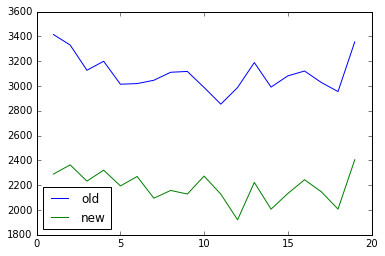

3101.66276289
2186.45621471
70.4930349253


In [19]:
old_RMSE = []
RMSE = []

test_frac = 0.31

for i in range(1,20):
    X_train, X_test, y_train, y_test = train_test_split(old_predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=i)
    old_mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    old_y_pred =  old_mod.predict(X_test)
    old_RMSE.append(math.sqrt(sum((old_y_pred-y_test)**2))/len(old_y_pred))
 
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=i)
    mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    y_pred =  mod.predict(X_test)
    RMSE.append(math.sqrt(sum((y_pred-y_test)**2))/len(y_pred))

fig = plt.figure()
plt.plot(range(1,20),old_RMSE,label="old")
plt.plot(range(1,20),RMSE,label="new")
plt.legend(loc='best')
plt.show()
print sum(old_RMSE)/len(old_RMSE)
print sum(RMSE)/len(RMSE)
print 100*(sum(RMSE)/len(RMSE))/(sum(old_RMSE)/len(old_RMSE))

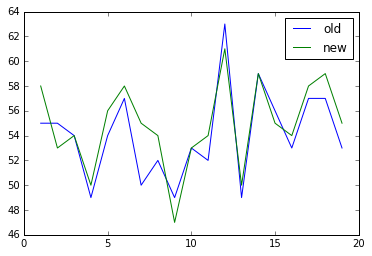

54.0526315789
54.8947368421


In [51]:
def metric(y_pred,y_test, top  = 100):
    return len(set([i[0] for i in sorted(enumerate(y_pred), key=lambda x:x[1],reverse=True)][0:top])
               .intersection([i[0] for i in sorted(enumerate(y_test), key=lambda x:x[1],reverse=True)][0:top]))



old_top = []
new_top = []

N = 20

l=100
np.random.seed(1)
for i in range(1,N):
    r = np.random.randint(1,4294967295)
    X_train, X_test, y_train, y_test = train_test_split(old_predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
    old_mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    old_y_pred =  old_mod.predict(X_test)
    old_top.append(metric(old_y_pred,y_test,l))
 
    X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=r)
    #mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
    mod=linear_model.Lasso(fit_intercept=False).fit(X_train,y_train)
    y_pred =  mod.predict(X_test)
    new_top.append(metric(y_pred,y_test,l))
if (N<30):
    fig = plt.figure()
    plt.plot(range(1,N),old_top,label="old")
    plt.plot(range(1,N),new_top,label="new")
    plt.legend(loc='best')
    plt.show()

print 1.0*sum(old_top)/len(old_top)
print 1.0*sum(new_top)/len(new_top)

In [ ]:
54.8947368421  #with std  Lasso
53.2631578947  #with std/daily Lasso
52.2105263158  #with std = 0  Lasso

In [456]:
s = np.random.randint(1,50)
X_train, X_test, y_train, y_test = train_test_split(old_predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=s)
old_mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
old_y_pred =  old_mod.predict(X_test)
old_RMSE = math.sqrt(sum((old_y_pred-y_test)**2))/len(old_y_pred)
print old_RMSE

X_train, X_test, y_train, y_test = train_test_split(predictors.as_matrix()[:,4:], output.as_matrix()[:,5], test_size=test_frac, random_state=s)
mod=linear_model.LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_pred =  mod.predict(X_test)
RMSE = (math.sqrt(sum((y_pred-y_test)**2))/len(y_pred))
print RMSE

3369.50269397
2442.85088556


In [457]:
#def metric(y_pred,y_test, top  = int(0.01*len(y_test))):
    #y_test_sorted = sorted(y_test,reverse=True)
    #y_pred_sorted = sorted(y_pred,reverse=True)
    #threshold_test = y_test_sorted[percent-1]
    #threshold_pred = y_pred_sorted[percent-1]
    #bool_test = np.greater_equal(y_test , np.ones(len(y_test))*threshold_test)
    #bool_pred = np.greater_equal(y_pred , np.ones(len(y_pred))*threshold_pred)
    #return sum(np.logical_and(bool_test,bool_pred))
    
#    return len(set([i[0] for i in sorted(enumerate(y_pred), key=lambda x:x[1],reverse=True)][0:top])
#               .intersection([i[0] for i in sorted(enumerate(y_test), key=lambda x:x[1],reverse=True)][0:top]))


print metric(old_y_pred,y_test,100)
print metric(y_pred,y_test,100)

50
53


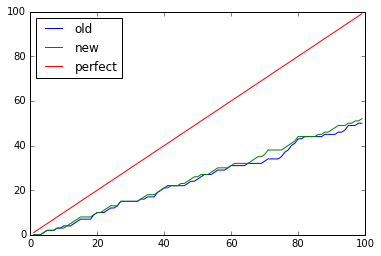

In [458]:


old_metric = []
new_metric = []

l = 100

a = [i[0] for i in sorted(enumerate(old_y_pred), key=lambda x:x[1],reverse=True)]
b = [i[0] for i in sorted(enumerate(y_test), key=lambda x:x[1],reverse=True)]
for x in range(1,l):
    old_metric.append(len(set(a[0:x]).intersection(b[0:x])))
a = [i[0] for i in sorted(enumerate(y_pred), key=lambda x:x[1],reverse=True)]
b = [i[0] for i in sorted(enumerate(y_test), key=lambda x:x[1],reverse=True)]
for x in range(1,l):
    new_metric.append(len(set(a[0:x]).intersection(b[0:x])))

fig = plt.figure()
plt.plot(range(1,l),old_metric,label="old")
plt.plot(range(1,l),new_metric,label="new")
plt.plot(range(1,l),range(1,l),label="perfect")
plt.legend(loc='best')
plt.show()

In [377]:

mod=linear_model.LinearRegression(fit_intercept=False).fit(predictors.as_matrix()[0:20000,4:],output.as_matrix()[0:20000,5])

In [353]:
predicted_downloads = mod.predict(predictors.as_matrix()[20001:32338,4:])

In [354]:
output.as_matrix()[20001:32338,5]

array([94491, 293977, 36748, ..., 10384, 4327, 4274], dtype=object)

In [355]:
predicted_downloads

array([ 209016.71444215,  452416.54865204,  132088.25934429, ...,
        141375.98515511,       0.        ,       0.        ])

In [356]:
print mod.score(predictors.as_matrix()[20001:32338,4:],output.as_matrix()[20001:32338,5])
RMSE = math.sqrt(sum((predicted_downloads-output.as_matrix()[20001:32338,5])**2))/(32338-20000)

0.504104007081


In [430]:
old_predictors = pd.concat([downloads["id"],downloads["name"],downloads["category"],downloads["device"],
   downloads['2015-03-01']+downloads['2015-03-02']+downloads['2015-03-03']+downloads['2015-03-04']+downloads['2015-03-05']+downloads['2015-03-06']+downloads['2015-03-07'],
   downloads['2015-03-08']+downloads['2015-03-09']+downloads['2015-03-10']+downloads['2015-03-11']+downloads['2015-03-12']+downloads['2015-03-13']+downloads['2015-03-14'],
   downloads['2015-03-15']+downloads['2015-03-16']+downloads['2015-03-17']+downloads['2015-03-18']+downloads['2015-03-19']+downloads['2015-03-20']+downloads['2015-03-21'],
   downloads['2015-03-22']+downloads['2015-03-23']+downloads['2015-03-24']+downloads['2015-03-25']+downloads['2015-03-26']+downloads['2015-03-27']+downloads['2015-03-28'],
   downloads['2015-03-29']+downloads['2015-03-30']+downloads['2015-03-31']+downloads['2015-04-01']+downloads['2015-04-02']+downloads['2015-04-03']+downloads['2015-04-04'],
   downloads['2015-04-05']+downloads['2015-04-06']+downloads['2015-04-07']+downloads['2015-04-08']+downloads['2015-04-09']+downloads['2015-04-10']+downloads['2015-04-11'],
   downloads['2015-04-12']+downloads['2015-04-13']+downloads['2015-04-14']+downloads['2015-04-15']+downloads['2015-04-16']+downloads['2015-04-17']+downloads['2015-04-18'],
   downloads['2015-04-19']+downloads['2015-04-20']+downloads['2015-04-21']+downloads['2015-04-22']+downloads['2015-04-23']+downloads['2015-04-24']+downloads['2015-04-25'],             
   ],axis=1,keys=["id","name","category","device","week1","week2","week3","week4","week5","week6","week7","week8"])

old_mod=linear_model.LinearRegression(fit_intercept=False).fit(old_predictors.as_matrix()[0:20000,4:],output.as_matrix()[0:20000,5])
old_predicted_downloads = old_mod.predict(old_predictors.as_matrix()[20001:32338,4:])
print old_mod.score(old_predictors.as_matrix()[20001:32338,4:],output.as_matrix()[20001:32338,5])
old_RMSE = math.sqrt(sum((old_predicted_downloads-output.as_matrix()[20001:32338,5])**2))/(32338-20000)

0.00246004412255


In [358]:
print RMSE
print old_RMSE

print 100*RMSE/old_RMSE 

2627.8975842
3727.1621423
70.506661204


In [305]:
len(y_pred)

10026

## Raw Plots

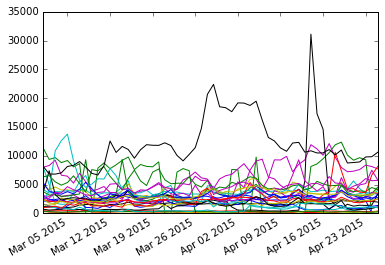

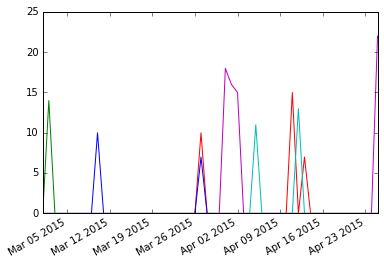

In [25]:
#Plot the "good" and "bad" apps downloads in 2 separate graphs
fig = plt.figure()
for i in range(MGood.shape[0]):
    plt.plot(pd.date_range('2015-03-01', periods=56),MGood[i])
fig.autofmt_xdate()
plt.show()

fig = plt.figure()
for i in range(MBad.shape[0]):
    plt.plot(pd.date_range('2015-03-01', periods=56),MBad[i])
fig.autofmt_xdate()
plt.show()

In [26]:
#A function to plot the downloads using an App id
def plotDownloads(id):
    downloadings = downloads[downloads["id"] == id][dateRange].as_matrix()
    downloadings = downloadings[0]
    fig = plt.figure()
    plt.plot(pd.date_range('2015-03-01', periods=56),downloadings)
    fig.autofmt_xdate()
    plt.show()


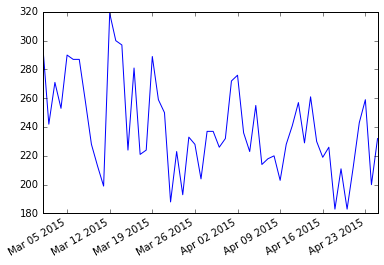

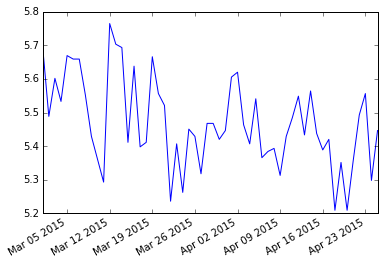

In [27]:
#ploting the log and the default downloadings
idOfApp = downloads["id"][3]
downloadings = downloads[downloads["id"] == idOfApp][dateRange].as_matrix()
downloadings = downloadings[0]
logDownloadings = map(math.log,downloadings)

fig = plt.figure()
plt.plot(pd.date_range('2015-03-01', periods=56),downloadings)
fig.autofmt_xdate()
plt.show()

fig = plt.figure()
plt.plot(pd.date_range('2015-03-01', periods=56),logDownloadings)
fig.autofmt_xdate()
plt.show()


Taking the log value does not seem to help

## Polynomial approximation

[  1.93616879e-02  -1.99917171e+00   2.74937419e+02]


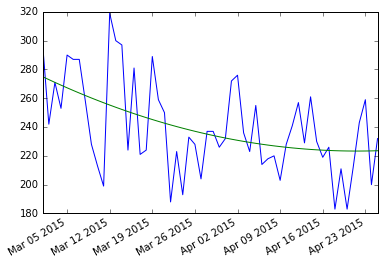

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55]


In [28]:
poly = np.polyfit(range(56),downloadings,2)
print poly
model = poly[2]+poly[1]*np.array(range(56))+poly[0]*np.array(range(56))*np.array(range(56))
#print model
fig = plt.figure()
plt.plot(pd.date_range('2015-03-01', periods=56),downloadings)
plt.plot(pd.date_range('2015-03-01', periods=56),model)
fig.autofmt_xdate()
plt.show()
print np.array(range(56))

In [29]:
#same in a function
def plotModelAndDownloads(id,deg=2):
    downloadings = downloads[downloads["id"] == idOfApp][dateRange].as_matrix()
    downloadings = downloadings[0]   
    poly = np.polyfit(range(56),downloadings,deg)
    model = 0
    r = np.ones(56)
    for i in range(deg+1):
        model = model+poly[deg-i]*r
        r = r*np.array(range(56))
    fig = plt.figure()
    plt.plot(pd.date_range('2015-03-01', periods=56),downloadings)
    plt.plot(pd.date_range('2015-03-01', periods=56),model)
    fig.autofmt_xdate()
    plt.show()
    return poly[::-1]
    


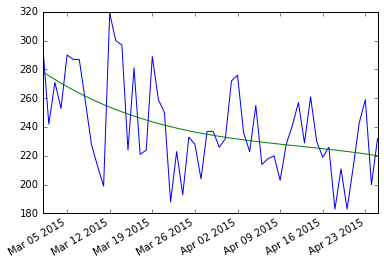

array([  2.78390843e+02,  -2.78840677e+00,   5.55611055e-02,
        -4.38780819e-04])

In [30]:
plotModelAndDownloads(downloads["id"][3],3)

## Weekly decomposition

In [56]:
#Create a sum of the downloads for each week
weekDownloads = pd.concat([downloads["id"],
   downloads['2015-03-01']+downloads['2015-03-02']+downloads['2015-03-03']+downloads['2015-03-04']+downloads['2015-03-05']+downloads['2015-03-06']+downloads['2015-03-07'],
   downloads['2015-03-08']+downloads['2015-03-09']+downloads['2015-03-10']+downloads['2015-03-11']+downloads['2015-03-12']+downloads['2015-03-13']+downloads['2015-03-14'],
   downloads['2015-03-15']+downloads['2015-03-16']+downloads['2015-03-17']+downloads['2015-03-18']+downloads['2015-03-19']+downloads['2015-03-20']+downloads['2015-03-21'],
   downloads['2015-03-22']+downloads['2015-03-23']+downloads['2015-03-24']+downloads['2015-03-25']+downloads['2015-03-26']+downloads['2015-03-27']+downloads['2015-03-28'],
   downloads['2015-03-29']+downloads['2015-03-30']+downloads['2015-03-31']+downloads['2015-04-01']+downloads['2015-04-02']+downloads['2015-04-03']+downloads['2015-04-04'],
   downloads['2015-04-05']+downloads['2015-04-06']+downloads['2015-04-07']+downloads['2015-04-08']+downloads['2015-04-09']+downloads['2015-04-10']+downloads['2015-04-11'],
   downloads['2015-04-12']+downloads['2015-04-13']+downloads['2015-04-14']+downloads['2015-04-15']+downloads['2015-04-16']+downloads['2015-04-17']+downloads['2015-04-18'],
   downloads['2015-04-19']+downloads['2015-04-20']+downloads['2015-04-21']+downloads['2015-04-22']+downloads['2015-04-23']+downloads['2015-04-24']+downloads['2015-04-25']]
   ,axis=1,keys=["id","week1","week2","week3","week4","week5","week6","week7","week8"])


In [32]:
weekDownloads[weekDownloads["id"] == 281704574].as_matrix()[0,1:9]

array([3587, 3209, 3125, 3392, 3055, 2625, 2295, 2998])

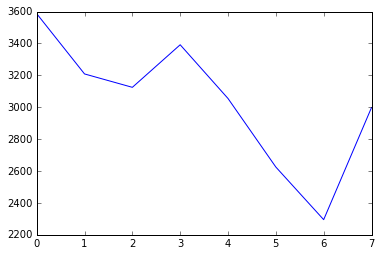

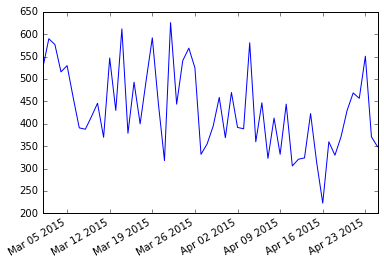

In [33]:
#A function to plot the downloads using an App id
def plotWeekDownloads(id):
    y = weekDownloads[weekDownloads["id"] == id].as_matrix()[0,1:9]
    fig = plt.figure()
    plt.plot(y)
    plt.show()
plotWeekDownloads(281704574)
plotDownloads(281704574)

# End of code here.
# .
# .
# .

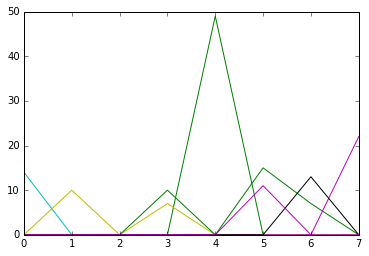

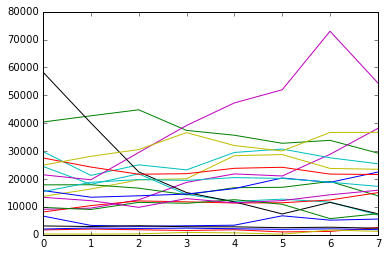

In [38]:
fig = plt.figure()
for id in badAppId:
    y = weekDownloads[weekDownloads["id"] == id].as_matrix()[0,1:9]
    plt.plot(y)
plt.show()
fig = plt.figure()
for id in goodAppId:
    y = weekDownloads[weekDownloads["id"] == id].as_matrix()[0,1:9]
    plt.plot(y)
plt.show()

In [39]:
for d in dateRange:
    print 0 in downloads[d].unique()


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [40]:
downloads


,Unnamed: 0,id,name,category,device,2015-03-01,2015-03-02,2015-03-03,2015-03-04,2015-03-05,...,2015-04-16,2015-04-17,2015-04-18,2015-04-19,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-25
0,0,281704574,"AIM: Chat, Free Text, Photo Share, Voice Message",Social Networking,iphone,524,590,577,516,530,...,223,360,330,371,430,469,457,551,371,349
1,1,281922769,Mobile MIM,Medical,ipad,67,64,46,55,60,...,56,57,85,60,55,58,48,55,55,48
2,2,281922769,Mobile MIM,Medical,iphone,102,99,89,86,95,...,75,83,84,0,92,86,84,94,115,98
3,3,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,ipad,297,242,271,253,290,...,219,226,183,211,183,212,243,259,200,232
4,4,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,iphone,1195,1088,1059,1098,1301,...,984,979,899,1039,971,975,1198,1086,1036,1381
5,5,284147312,iTrans DC Metro,Navigation,iphone,629,619,506,477,547,...,614,585,604,630,576,684,580,683,642,587
6,6,284574017,Units - Free Unit Converter,Utilities,ipad,127,97,48,60,72,...,75,59,91,77,161,276,152,206,234,153
7,7,284574017,Units - Free Unit Converter,Utilities,iphone,0,0,0,425,0,...,0,0,0,0,533,726,689,811,649,911
8,8,284735786,Compass Free,Utilities,ipad,35,25,32,27,27,...,45,59,60,50,77,79,86,33,35,35
9,9,284776127,"Shopper - Grocery List, Shopping List and Recipes",Shopping,ipad,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


ValueError: could not convert string to float: Snap Up For Snapchat - Send photos & videos from your camera roll

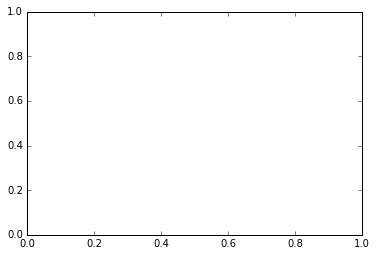

In [41]:
plt.figure(); 
plt.plot(goodAppDownloads,label="Good App");
plt.plot(badAppDownloads,label="Bad App")
plt.legend(loc='best')
plt.show()

In [ ]:
goodAppDownloads.type

In [ ]:
downloads.columns


In [ ]:
pd.date_range('2015-03-01', periods=56).format(formatter=lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
MGood

In [42]:
output


,Unnamed: 0,id,name,category,device,cumulative_downloads_2016-02
0,0,281704574,"AIM: Chat, Free Text, Photo Share, Voice Message",Social Networking,iphone,753496
1,1,281922769,Mobile MIM,Medical,ipad,100804
2,2,281922769,Mobile MIM,Medical,iphone,111613
3,3,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,ipad,370383
4,4,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,iphone,1330247
5,5,284147312,iTrans DC Metro,Navigation,iphone,886720
6,6,284574017,Units - Free Unit Converter,Utilities,ipad,194504
7,7,284574017,Units - Free Unit Converter,Utilities,iphone,337464
8,8,284735786,Compass Free,Utilities,ipad,122824
9,9,284776127,"Shopper - Grocery List, Shopping List and Recipes",Shopping,ipad,642


[249865 46895 41939 ..., 527696 635066 44745]


In [475]:
predictors

,id,name,category,device,week_1,week_2,week_3,week_4,week_5,week_6,...,coef_0,coef_1,coef_2,coef_3,maxStep,minStep,std,daily_avg,iphone,ipad
0,281704574,"AIM: Chat, Free Text, Photo Share, Voice Message",Social Networking,iphone,6.239161,6.127804,6.101279,6.183265,6.078625,5.926926,...,433.678571,-2.585304,0.035204,0.003661,308,-233,91.952066,433.678571,1,0
1,281922769,Mobile MIM,Medical,ipad,4.075113,4.084775,3.964886,4.198275,4.089571,4.027899,...,58.678571,-0.028161,-0.005040,-0.000418,28,-34,8.860239,58.678571,0,1
2,281922769,Mobile MIM,Medical,iphone,4.576183,4.532599,4.418841,4.507715,4.480578,4.464265,...,86.642857,-0.149146,0.010635,-0.000346,31,-20,19.594486,89.851852,1,0
3,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,ipad,5.617810,5.557379,5.520317,5.371302,5.493649,5.418637,...,239.660714,-0.934279,0.019362,-0.000439,120,-73,31.992341,239.660714,0,1
4,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,iphone,7.038282,7.073875,7.173192,7.016097,7.020318,7.022613,...,1150.660714,-1.639337,-0.069742,0.006644,394,-276,154.055797,1150.660714,1,0
5,284147312,iTrans DC Metro,Navigation,iphone,6.340107,6.486814,6.627474,6.550468,6.656359,6.727432,...,705.017857,1.771258,-0.272778,-0.007031,302,-286,125.918978,705.017857,1,0
6,284574017,Units - Free Unit Converter,Utilities,ipad,4.513994,4.163337,4.129436,4.223701,4.169982,4.313671,...,84.964286,1.199111,0.112912,0.003346,115,-124,45.913336,84.964286,0,1
7,284574017,Units - Free Unit Converter,Utilities,iphone,6.052089,5.997695,6.167516,6.042633,0.000000,0.000000,...,122.642857,5.276897,0.493237,0.037758,262,-162,247.844596,572.333333,1,0
8,284735786,Compass Free,Utilities,ipad,3.579543,3.695997,3.797093,3.925268,3.909162,3.703064,...,43.857143,0.257553,-0.000722,0.000748,67,-63,19.078249,45.481481,0,1
9,284776127,"Shopper - Grocery List, Shopping List and Recipes",Shopping,ipad,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.000000,0,1


In [441]:
old_predictors


,id,name,category,device,week1,week2,week3,week4,week5,week6,week7,week8
0,281704574,"AIM: Chat, Free Text, Photo Share, Voice Message",Social Networking,iphone,3587,3209,3125,3392,3055,2625,2295,2998
1,281922769,Mobile MIM,Medical,ipad,412,416,369,466,418,393,433,379
2,281922769,Mobile MIM,Medical,iphone,680,651,498,635,618,608,593,569
3,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,ipad,1927,1814,1748,1506,1702,1579,1605,1540
4,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,iphone,7976,8265,9128,7801,7834,7852,7895,7686
5,284147312,iTrans DC Metro,Navigation,iphone,3968,4595,5289,4897,5444,5845,5061,4382
6,284574017,Units - Free Unit Converter,Utilities,ipad,639,450,435,478,453,523,521,1259
7,284574017,Units - Free Unit Converter,Utilities,iphone,425,805,477,842,0,0,0,4319
8,284735786,Compass Free,Utilities,ipad,251,282,312,304,349,284,279,395
9,284776127,"Shopper - Grocery List, Shopping List and Recipes",Shopping,ipad,0,0,0,0,0,0,0,0


In [400]:
old_mod.coef_


array([ 27.56093779,   2.00829431,   0.57013361,  14.03803048,
        -1.40412263,  15.05682149,  -3.80932832,  19.79754647])

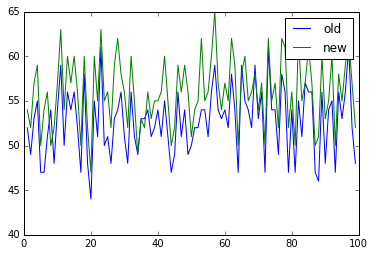

In [439]:

fig = plt.figure()
plt.plot(range(1,100),old_top,label="old")
plt.plot(range(1,100),new_top,label="new")
plt.legend()
plt.show()

In [470]:
downloads


,Unnamed: 0,id,name,category,device,2015-03-01,2015-03-02,2015-03-03,2015-03-04,2015-03-05,...,2015-04-16,2015-04-17,2015-04-18,2015-04-19,2015-04-20,2015-04-21,2015-04-22,2015-04-23,2015-04-24,2015-04-25
0,0,281704574,"AIM: Chat, Free Text, Photo Share, Voice Message",Social Networking,iphone,524,590,577,516,530,...,223,360,330,371,430,469,457,551,371,349
1,1,281922769,Mobile MIM,Medical,ipad,67,64,46,55,60,...,56,57,85,60,55,58,48,55,55,48
2,2,281922769,Mobile MIM,Medical,iphone,102,99,89,86,95,...,75,83,84,0,92,86,84,94,115,98
3,3,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,ipad,297,242,271,253,290,...,219,226,183,211,183,212,243,259,200,232
4,4,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,iphone,1195,1088,1059,1098,1301,...,984,979,899,1039,971,975,1198,1086,1036,1381
5,5,284147312,iTrans DC Metro,Navigation,iphone,629,619,506,477,547,...,614,585,604,630,576,684,580,683,642,587
6,6,284574017,Units - Free Unit Converter,Utilities,ipad,127,97,48,60,72,...,75,59,91,77,161,276,152,206,234,153
7,7,284574017,Units - Free Unit Converter,Utilities,iphone,0,0,0,425,0,...,0,0,0,0,533,726,689,811,649,911
8,8,284735786,Compass Free,Utilities,ipad,35,25,32,27,27,...,45,59,60,50,77,79,86,33,35,35
9,9,284776127,"Shopper - Grocery List, Shopping List and Recipes",Shopping,ipad,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
np.random.seed(1)
np.random.randint(20000000)

12710949

In [52]:
predictors

,id,name,category,device,week_1,week_2,week_3,week_4,week_5,week_6,...,daily_avg,coef_0,coef_1,coef_2,coef_3,maxStep,minStep,std,iphone,ipad
0,281704574,"AIM: Chat, Free Text, Photo Share, Voice Message",Social Networking,iphone,6.239161,6.127804,6.101279,6.183265,6.078625,5.926926,...,433.678571,433.678571,-2.585304,0.035204,0.003661,308,-233,91.952066,1,0
1,281922769,Mobile MIM,Medical,ipad,4.075113,4.084775,3.964886,4.198275,4.089571,4.027899,...,58.678571,58.678571,-0.028161,-0.005040,-0.000418,28,-34,8.860239,0,1
2,281922769,Mobile MIM,Medical,iphone,4.576183,4.532599,4.418841,4.507715,4.480578,4.464265,...,89.851852,86.642857,-0.149146,0.010635,-0.000346,31,-20,19.594486,1,0
3,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,ipad,5.617810,5.557379,5.520317,5.371302,5.493649,5.418637,...,239.660714,239.660714,-0.934279,0.019362,-0.000439,120,-73,31.992341,0,1
4,281935788,Epocrates References & Tools for Healthcare Pr...,Medical,iphone,7.038282,7.073875,7.173192,7.016097,7.020318,7.022613,...,1150.660714,1150.660714,-1.639337,-0.069742,0.006644,394,-276,154.055797,1,0
5,284147312,iTrans DC Metro,Navigation,iphone,6.340107,6.486814,6.627474,6.550468,6.656359,6.727432,...,705.017857,705.017857,1.771258,-0.272778,-0.007031,302,-286,125.918978,1,0
6,284574017,Units - Free Unit Converter,Utilities,ipad,4.513994,4.163337,4.129436,4.223701,4.169982,4.313671,...,84.964286,84.964286,1.199111,0.112912,0.003346,115,-124,45.913336,0,1
7,284574017,Units - Free Unit Converter,Utilities,iphone,6.052089,5.997695,6.167516,6.042633,0.000000,0.000000,...,572.333333,122.642857,5.276897,0.493237,0.037758,262,-162,247.844596,1,0
8,284735786,Compass Free,Utilities,ipad,3.579543,3.695997,3.797093,3.925268,3.909162,3.703064,...,45.481481,43.857143,0.257553,-0.000722,0.000748,67,-63,19.078249,0,1
9,284776127,"Shopper - Grocery List, Shopping List and Recipes",Shopping,ipad,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0,0,0.000000,0,1
